In [82]:
%cd ../..
%load_ext autoreload
%autoreload 2

/home
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

# Export cache tables for streamlit app

## All foraging sessions

In [163]:
def fetch_sessions():
    # with st.spinner(f'Connect to datajoint...'):
    
    # with st.spinner(f'Fetching...'):
    foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
    insertion_numbers = foraging_sessions.aggr(foraging_sessions * ephys.ProbeInsertion, ..., 
                                                    #   keep_all_rows=True, ephys_insertions='IF(COUNT(insertion_number), "yes", "no")')
                                                keep_all_rows=True, ephys_ins='COUNT(insertion_number)')
    if_histology = foraging_sessions.aggr(foraging_sessions * histology.ElectrodeCCFPosition.ElectrodePosition, ...,
                                          keep_all_rows=True, histology='IF(COUNT(ccf_x)>0, "yes", "no")')
    if_photostim_from_behav = foraging_sessions.aggr(foraging_sessions * experiment.PhotostimForagingTrial, ...,
                                          keep_all_rows=True, photostim_behav='IF(COUNT(trial)>0, "yes", "no")')
    if_photostim_from_ephys = foraging_sessions.aggr(foraging_sessions * (ephys.TrialEvent & 'trial_event_type LIKE "laser%"'), ...,
                                          keep_all_rows=True, photostim_NI='IF(COUNT(trial)>0, "yes", "no")')

    df_sessions = pd.DataFrame(((experiment.Session & foraging_sessions)
                                * lab.WaterRestriction.proj(h2o='water_restriction_number')
                                * insertion_numbers
                                * if_histology
                                * if_photostim_from_behav
                                * if_photostim_from_ephys)
                               .proj(..., '-rig', '-username', '-session_time')
                               .fetch()
                                )
    # df_sessions['session_date'] = pd.to_datetime(df_sessions['session_date'], format="%Y-%m-%d")
    df_sessions.to_pickle(cache_folder + 'sessions.pkl')
    
    return df_sessions

fetch_sessions()

,subject_id,session,session_date,h2o,ephys_ins,histology,photostim_behav,photostim_NI
0,447921,1,2019-09-11,HC16,0,no,no,no
1,447921,2,2019-09-12,HC16,0,no,no,no
2,447921,3,2019-09-13,HC16,0,no,no,no
3,447921,4,2019-09-14,HC16,0,no,no,no
4,447921,5,2019-09-15,HC16,0,no,no,no
...,...,...,...,...,...,...,...,...
2152,642858,3,2022-11-04,KH_FB55,0,no,no,no
2153,642858,4,2022-11-07,KH_FB55,0,no,no,no
2154,642858,5,2022-11-08,KH_FB55,0,no,no,no
2155,642858,6,2022-11-09,KH_FB55,0,no,no,no


## Ephys units

In [211]:
def reorder_df(df, column_name, new_loc):
    tmp = df[column_name]
    df = df.drop(columns=[column_name])
    df.insert(loc=new_loc, column=column_name, value=tmp)
    return df

In [230]:
cache_folder = '~/s3-drive/report/st_cache/'

# def fetch_ephys_units():
# df = pd.DataFrame(all_unit_qc.fetch())

# --- Prepare queries ---
q_ccf = (histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation).proj()

q_all_unit = (report.UnitLevelForagingEphysReportAllInOne.proj()   # With behavior QC and miminal unit QC
                * ephys.Unit.proj('unit_uid', 'unit_amp', 'unit_snr', 'electrode')
                * q_ccf
                * experiment.Session.proj(session_date="cast(concat(session_date) as datetime)")
                * ephys.ClusterMetric.proj('presence_ratio', 'amplitude_cutoff')
                * ephys.UnitStat.proj('isi_violation', 'avg_firing_rate')
                )

# --- Fetch dataframe ---
df_all_unit = q_all_unit.fetch(format='frame')

# --- Prepare t and betas of period linear fitting ---
df_t_beta = (psth_foraging.UnitPeriodLinearFit.Param & 'multi_linear_model IN ("Q_rel + Q_tot + rpe", "Q_c + Q_i + rpe")' & 'period IN ("iti_all", "go_to_end")'
        & q_all_unit).fetch(format="frame").reset_index()  # Fetch all fitting paras
df_t_beta = df_t_beta.pivot(index=['subject_id', 'session', 'insertion_number', 'unit'], 
                            columns=['multi_linear_model', 'var_name', 'period'], values=['t', 'beta']
                           ).dropna()
df_t_beta = df_t_beta.rename({'contra_action_value': 'contraQ',            
                              'ipsi_action_value': 'ipsiQ', 
                              'relative_action_value_ic': 'dQ', 
                              'total_action_value': 'sumQ',
                              'go_to_end': 'trial', 
                              'iti_all': 'iti'}, axis=1)
col = df_t_beta.columns
df_t_beta = df_t_beta.drop(col[(col.get_level_values(1)=='Q_c + Q_i + rpe') & 
                               (col.get_level_values(2)=='rpe')], axis=1    # Drop rpe from one of the models (exactly the same)
                          ).droplevel(1, axis=1)

df_t_beta.columns = ['_'.join(ind) for ind in df_t_beta.columns]  # Flat column

# --- Prepare p_model ---
df_p_model = (psth_foraging.UnitPeriodLinearFit & 'multi_linear_model IN ("Q_rel + Q_tot + rpe")' & 'period IN ("iti_all", "go_to_end")'
        & q_all_unit).fetch(format="frame").reset_index()  # Fetch all fitting paras. Different models have the same p because they are linear transformation from each other
df_p_model = df_p_model.pivot(index=['subject_id', 'session', 'insertion_number', 'unit'], 
                 columns=['period'], values='model_p'
                ).dropna().rename({'go_to_end': 'p_model_trial', 'iti_all': 'p_model_iti'}, axis=1)

# df_fittings = df.join(np.abs(df), how="left", rsuffix="_abs")  # Add abs

# --- Merge together ---
df_all_unit = df_all_unit.join(df_t_beta, how="right").join(df_p_model).reset_index()


# --- Turn datajoint ccf to Allen ccf ---
ccf_x = df_all_unit.ccf_z
ccf_y = df_all_unit.ccf_y
ccf_z = 5739 * 2 - df_all_unit.ccf_x
df_all_unit.ccf_x, df_all_unit.ccf_y, df_all_unit.ccf_z = ccf_x, ccf_y, ccf_z

# --- Add h2o ---
df_h2o = lab.WaterRestriction.proj(h2o='water_restriction_number').fetch(format='frame') # I don't know why it's faster by doing this...
df_all_unit = df_all_unit.merge(df_h2o, on='subject_id')

# --- Add AOI ---
df_AOI = ccf.AreaOfInterest.CCFBrainRegionIncluded.proj(annotation='region_name').fetch(format='frame')
df_all_unit = df_all_unit.merge(df_AOI.reset_index().drop('id', axis=1), how='left', on='annotation').fillna('others')  # Add area of interest
df_all_unit.drop(['clustering_method', 'probe_type', 'electrode_config_name', 'electrode_group', 'ccf_label_id', 'annotation_version', 'unit_uid', 'epoch_name_quality_metrics']
                 , axis=1, inplace=True)

df_all_unit.rename(columns={'insertion_number': 'ins'}, inplace=True)
df_all_unit = df_all_unit.round(3)

# --- Add uid over all units exported ---
df_all_unit.insert(loc=0, column='uid', value=df_all_unit.index)

# reorder columns
df_all_unit = reorder_df(df_all_unit, 'area_of_interest', 1)
df_all_unit = reorder_df(df_all_unit, 'h2o', 2)
df_all_unit = reorder_df(df_all_unit, 'session_date', 8)


#df_all_unit.to_pickle(cache_folder + 'ephys_units.pkl')
   
    # return df_all_unit

#df_all_unit = fetch_ephys_units()

In [232]:
df_all_unit.to_pickle(cache_folder + 'ephys_units.pkl')

In [231]:
df_all_unit

,uid,area_of_interest,h2o,subject_id,session,ins,unit,electrode,session_date,ccf_x,...,beta_dQ_trial,beta_rpe_trial,beta_sumQ_trial,beta_contraQ_iti,beta_ipsiQ_iti,beta_dQ_iti,beta_rpe_iti,beta_sumQ_iti,p_model_trial,p_model_iti
0,0,others,HH08,473360,49,2,13,9,2021-08-12,5100,...,0.397,-0.593,0.119,0.736,0.693,0.022,-0.399,0.715,0.000,0.029
1,1,others,HH08,473360,49,2,16,11,2021-08-12,5080,...,0.066,0.091,0.458,-0.178,-0.350,0.086,0.185,-0.264,0.012,0.023
2,2,others,HH08,473360,49,2,24,33,2021-08-12,4940,...,-0.122,0.322,0.001,-0.498,-0.347,-0.075,0.280,-0.423,0.003,0.001
3,3,others,HH08,473360,49,2,25,21,2021-08-12,5020,...,-0.116,0.176,0.358,-0.275,0.137,-0.206,-0.213,-0.069,0.287,0.041
4,4,others,HH08,473360,49,2,27,20,2021-08-12,5020,...,0.134,1.394,-0.841,-1.028,-1.569,0.270,1.307,-1.299,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4582,4582,ALM,HH16,494691,18,3,72,308,2021-12-09,3460,...,-0.550,0.328,0.435,0.846,0.578,0.134,0.159,0.712,0.000,0.000
4583,4583,ALM,HH16,494691,18,3,80,320,2021-12-09,3420,...,0.045,3.161,1.623,1.078,1.856,-0.389,0.973,1.467,0.000,0.000
4584,4584,ALM,HH16,494691,18,3,90,346,2021-12-09,3360,...,-4.852,0.014,4.078,-0.067,6.559,-3.313,0.599,3.246,0.000,0.000
4585,4585,ALM,HH16,494691,18,3,92,350,2021-12-09,3340,...,-5.645,0.059,5.243,0.528,10.412,-4.942,-0.655,5.470,0.000,0.000


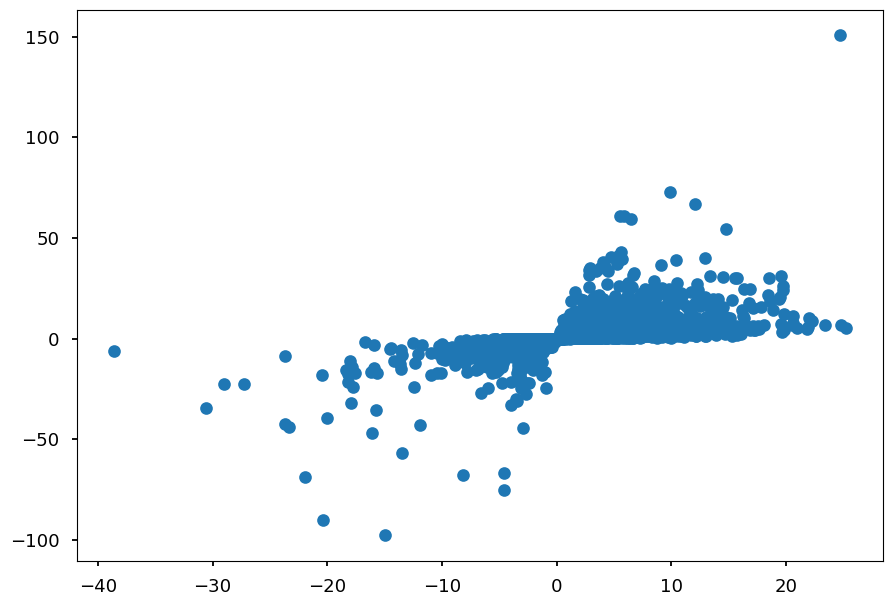

In [107]:
plt.plot(df_t_beta['t']["Q_c + Q_i + rpe"]['contra_action_value']['iti_all'], df_t_beta['beta']['Q_c + Q_i + rpe']['contra_action_value']['iti_all'], 'o')

### Export ccf

In [25]:
vertices, faces = ccf.AnnotatedBrainSurface.fetch1('vertices', 'faces')

In [29]:
vertices.shape

(102295, 3)

In [28]:
faces.shape

(204280, 3)

In [30]:
ccf.CCFAnnotation()

ccf_label_id Local CCF ID,ccf_x (um),ccf_y (um),ccf_z (um),annotation_version e.g. CCF_2017,annotation
0,540,3420,7820,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7840,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7860,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7880,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7900,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7920,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7940,CCF_2017,"Ventral auditory area, layer 1"
0,540,3440,7800,CCF_2017,"Ventral auditory area, layer 1"
0,540,3440,7820,CCF_2017,"Ventral auditory area, layer 1"
0,540,3440,7840,CCF_2017,"Ventral auditory area, layer 1"


# Miscs

## Add `AreaOfInterest` lookup table

In [ ]:
ccf.AreaOfInterest.drop()

In [7]:
ccf.AreaOfInterest.CCFBrainRegionIncluded()

area_of_interest,id,annotation_version e.g. CCF_2017,region_name
OLF,0,CCF_2017,Accessory olfactory bulb
OLF,1,CCF_2017,"Accessory olfactory bulb, glomerular layer"
OLF,2,CCF_2017,"Accessory olfactory bulb, granular layer"
OLF,3,CCF_2017,"Accessory olfactory bulb, mitral layer"
OLF,4,CCF_2017,accessory olfactory tract
ACA,0,CCF_2017,Anterior cingulate area
ACA,1,CCF_2017,"Anterior cingulate area, dorsal part"
ACA,2,CCF_2017,"Anterior cingulate area, dorsal part, layer 1"
ACA,3,CCF_2017,"Anterior cingulate area, dorsal part, layer 2/3"
ACA,4,CCF_2017,"Anterior cingulate area, dorsal part, layer 5"


In [69]:
lab.Person()

username,fullname
daiek,Kayvon Daie
daveliu,Dave Liu
HH,Han Hou
Kenta,Kenta Hagihara
liangy10,Yajie Liang
Lucas,Lucas Kinsey
NT,Nai-Wen Tien
rozsam,Marton Rozsa
singha,Amrita Singh
Smrithi,Smrithi Sunil


In [70]:
lab.Person.insert1({'username': 'LucasK', 'fullname': 'Lucas Kinsey'})

In [71]:
lab.Person()

username,fullname
daiek,Kayvon Daie
daveliu,Dave Liu
HH,Han Hou
Kenta,Kenta Hagihara
liangy10,Yajie Liang
Lucas,Lucas Kinsey
LucasK,Lucas Kinsey
NT,Nai-Wen Tien
rozsam,Marton Rozsa
singha,Amrita Singh
